# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [3]:
# Python 3.6 or above is required
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import urllib
import progressbar
import sklearn
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import  StackingClassifier
import pandas as pd
import seaborn as sns

/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [11]:
PATH_TO_DATA = Path('../data/')
#PATH_TO_DATA = Path('/content/')# for colab

# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'

if not en_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)

fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [12]:
class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        if word in self.word2id.keys():
            idi=self.word2id[word]
            return(self.embeddings[idi])
        else:
            return(None)
            
    
    def score(self, word1, word2):
        e1=self.encode(word1)
        e2=self.encode(word2)
        return(np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)))
  
    def most_similar(self, word, k=5):
        scores=[]
        for w in self.words:
            scores.append(self.score(word,w))
        return([self.words[i] for i in np.argsort(scores)[::-1][1:(k+1)]])

        

In [13]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(word2vec.most_similar(word,k=10))

Loaded 50000 pretrained word vectors
cat tree 0.26449754661654756
cat dog 0.7078641298542564
cat pet 0.6753313359976382
Paris France 0.6892958925806543
Paris Germany 0.4051242286737549
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348003
['cats', 'kitty', 'kitten', 'feline', 'dog', 'kitties', 'kittens', 'pet', 'Cat', 'puppy']
['dogs', 'puppy', 'pup', 'canine', 'pet', 'doggie', 'cat', 'pooch', 'poodle', 'Dog']
['dog', 'cats', 'puppies', 'Dogs', 'pets', 'canine', 'puppy', 'pup', 'pups', 'doggie']
['France', 'Parisian', 'Marseille', 'Brussels', 'Strasbourg', 'Toulouse', 'paris', 'Lille', 'Nantes', 'Versailles']
['Austria', 'Europe', 'Berlin', 'Hamburg', 'Bavaria', 'Munich', 'Stuttgart', 'Switzerland', 'germany', 'Leipzig']


In [16]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec

    def build_idf(self,sentences):
        "Words that appear only in a few documents contain more discriminative information"
        dic = {}
        for st in sentences: 
            for word in set(st.split()):
                if word in dic.keys():
                    dic[word] += 1
                else: 
                    dic[word] = 1
                
        N = len(sentences)
        idf = {word:np.log(N/n_word) for (word,n_word) in progressbar.progressbar(dic.items())}
        self.idf = idf
        return idf
 
    
    def encode(self, sentence, idf=None):
        # Takes a sentence as input, returns the sentence embedding
        
        words=sentence.split()
        word_vectors=[self.word2vec.encode(word) for word in words]
        word_vectors_filled = [word for word in word_vectors if word is not None] 
        if idf is None:
            # mean of word vectors
            return(np.mean(word_vectors_filled,axis=0))
            
        else:
            # idf-weighted mean of word vectors
            idf_used=[idf.get(words[i]) for  i in range(len(words)) if word_vectors[i] is not None]
            idf_used=np.nan_to_num(np.array(idf_used,dtype=float),nan=1)
           
            return(np.average(word_vectors_filled,weights=idf_used,axis=0))
            
    def score(self, sentence1, sentence2, idf=None):
        # cosine similarity: use np.dot & np.linalg.norm 
        e1=self.encode(sentence1,idf)
        e2=self.encode(sentence2,idf)
        return(np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)))
    
    def most_similar(self, sentence, sentences, idf=None, k=5):
        # Return most similar sentences
        query = self.encode(sentence, idf)
        keys = [self.encode(sentence, idf) for sentence in sentences]
        scores=[]
        for key in keys:
            scores.append(np.dot(key,query)/(np.linalg.norm(key)*np.linalg.norm(query)))
        return([sentences[i] for i in np.argsort(scores)[::-1][1:(k+1)]])
    
        

In [17]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:

sentence1 = sentences[7]
sentence2 = sentences[13]

#without idf
print('\n\tAverage of word embeddings')
print("sentence 1:",sentence1)
print("sentence 2:",sentence2)
print(sentence2vec.score(sentence1, sentence2))


# with idf

print('\n\tidf weighted average of word embeddings')
print("idf building")
idf = sentence2vec.build_idf(sentences)

print("sentence 1:",sentence1)
print("sentence 2:",sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))


#search of similar sentences

sentence= sentences[10]

print("start sentence :",sentence)
print("search for similar sentences")

# without idf
print("without idf")
similar_sentences = sentence2vec.most_similar(sentence, sentences)  # BagOfWords-mean
for i, sent in enumerate(similar_sentences):
    print(str(i+1) + ')', sent)

#with idf
print("with idf")
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
for i, sent in enumerate(similar_sentences):
    print(str(i+1) + ')', sent)

Loaded 50000 pretrained word vectors

	Average of word embeddings
sentence 1: 1 man singing and 1 man playing a saxophone in a concert . 
sentence 2: 10 people venture out to go crosscountry skiing . 
0.7065220648251475

	idf weighted average of word embeddings
idf building


100% (19976 of 19976) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


sentence 1: 1 man singing and 1 man playing a saxophone in a concert . 
sentence 2: 10 people venture out to go crosscountry skiing . 
0.6400799939346387
start sentence : 1 smiling african american boy . 
search for similar sentences
without idf
1) 2 woman dancing while pointing . 
2) 5 women and 1 man are smiling for the camera . 
3) a small boy following 4 geese . 
4) 2 female babies eating chips . 
5) a young boy and 2 girls open christmas presents . 
with idf
1) 1 man singing and 1 man playing a saxophone in a concert . 
2) two women and 1 man walking across the street . 
3) 3 males and 1 woman enjoying a sporting event 
4) 5 women and 1 man are smiling for the camera . 
5) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [7]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        #     Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        A=set(self.fr_word2vec.word2id)
        B=set(self.en_word2vec.word2id)
        list_anchor=A.intersection(B)
        
        X=np.array([self.fr_word2vec.encode(anchor) for anchor in list_anchor]).T
        Y=np.array([self.en_word2vec.encode(anchor) for anchor in list_anchor]).T

        assert X.shape[0] == 300 and Y.shape[0] == 300
        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings
        SVD=np.linalg.svd(np.dot(Y,X.T))
        U=SVD[0]
        V_T=SVD[2]
        W=np.dot(U,V_T)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        
        fr_word_en_space=self.get_aligned_fr_embeddings()#fr word in en space
        #encode french word in english space
        
        if fr_word in self.fr_word2vec.word2id.keys():
            idi=self.fr_word2vec.word2id[fr_word]
            e1=(fr_word_en_space[idi])
        else:
            e1=None # In e1 french word is encoded in english
       
    # 3 - Return the top k English nearest neighbors to the input French word
        
        scores=[]
        for w in self.en_word2vec.words:
            e2=self.en_word2vec.encode(w)
            scores.append(np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)))
        
        return([self.en_word2vec.words[i] for i in np.argsort(scores)[::-1][0:k]])


       

In [18]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut','amour','gloire','france']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words:
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors


NameError: name 'MultilingualWordAligner' is not defined

If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [20]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

y_train=[]
x_train=[]
with open(train_filepath, 'r') as f:
    for line in f:
        y, x = line.split(' ', 1)
        y_train.append(y)
        x_train.append(x.strip('\n'))

y_dev=[]
x_dev=[]
with open(dev_filepath, 'r') as f:
    for line in f:
        y, x = line.split(' ', 1)
        y_dev.append(y)
        x_dev.append(x.strip('\n'))

x_test=[]
with open(test_filepath, 'r') as f:
    for line in f:
        x_test.append(line.strip('\n'))


In [21]:
# 2 - Encode sentences with the BoV model above
n_train=len(x_train)
n_dev=len(x_dev)
n_test=len(x_test)
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

x_encode_train=np.zeros((n_train,300))
x_encode_dev=np.zeros((n_dev,300))
x_encode_test=np.zeros((n_test,300))


x_encode_train_idf=np.zeros((n_train,300))
x_encode_dev_idf=np.zeros((n_dev,300))
x_encode_test_idf=np.zeros((n_test,300))

idf = sentence2vec.build_idf(x_train) #idf only build on x_train

for i in range(n_train):
    x_encode_train[i,]= sentence2vec.encode(x_train[i])
    x_encode_train_idf[i,]= sentence2vec.encode(x_train[i],idf=idf)
for i in range(n_dev):
    x_encode_dev[i,]= sentence2vec.encode(x_dev[i])
    x_encode_dev_idf[i,]= sentence2vec.encode(x_dev[i],idf=idf)
for i in range(n_test):
    x_encode_test[i,]= sentence2vec.encode(x_test[i])
    x_encode_test_idf[i,]= sentence2vec.encode(x_test[i],idf=idf)
    

Loaded 50000 pretrained word vectors


100% (16579 of 16579) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


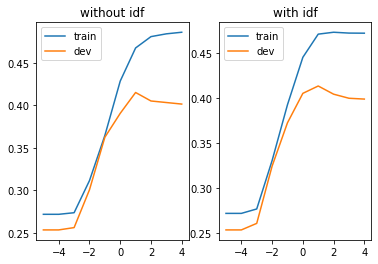

without_idf: 0.4150772025431426 with_idf: 0.41326067211625794


In [22]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
@ignore_warnings(category=ConvergenceWarning)
def logreg():
    list_score_train=[]
    list_score_dev=[]
    
    #In order to find the good  regularization parameter 
    for i in range(-5,5): 
        LogReg=LogisticRegression(C=10**i, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)
        LogReg.fit(x_encode_train,y_train)
        list_score_train.append(LogReg.score(x_encode_train,y_train))    
        list_score_dev.append(LogReg.score(x_encode_dev,y_dev))

    list_score_train_idf=[]
    list_score_dev_idf=[]
    for i in range(-5,5): 
        LogReg=LogisticRegression(C=10**i, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)
        LogReg.fit(x_encode_train_idf,y_train)
        list_score_train_idf.append(LogReg.score(x_encode_train_idf,y_train))
        list_score_dev_idf.append(LogReg.score(x_encode_dev_idf,y_dev))

    plt.subplot(1,2,1)
    plt.title("without idf")
    a,=plt.plot(range(-5,5),list_score_train,label="train")
    b,=plt.plot(range(-5,5),list_score_dev,label="dev")
    plt.legend(handles=[a,b])
    
   
    plt.subplot(1,2,2)
    plt.title("with idf")
    c,=plt.plot(range(-5,5),list_score_train_idf,label="train")
    d,=plt.plot(range(-5,5),list_score_dev_idf,label="dev")
    plt.legend(handles=[c,d])
    
    plt.show()

logreg()

#finally

#Erase
LogReg=LogisticRegression(C=10, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)
LogReg.fit(x_encode_train,y_train)
  
LogReg_idf=LogisticRegression(C=10, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)
LogReg_idf.fit(x_encode_train_idf,y_train)

print("without_idf:",LogReg.score(x_encode_dev,y_dev),"with_idf:",LogReg_idf.score(x_encode_dev_idf,y_dev))

#adding idf does not improve the results

In [32]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

LogReg_final=LogisticRegression(C=10, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)
LogReg_final.fit(x_encode_train,y_train)

y_test_pred= LogReg_final.predict(x_encode_test)
with open("logreg_bow_y_test_sst.txt",'w') as f: 
    for pred in y_test_pred:
        f.write(str(pred)+'\n')


/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


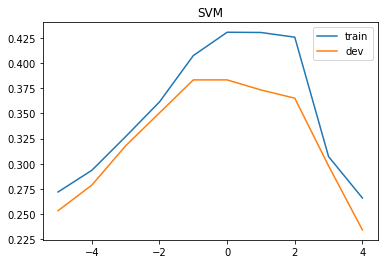

logistic regression:  0.4150772025431426
Linear SVM:  0.3832879200726612
Random Forest:  0.34150772025431425
stacking:  0.4032697547683924


/Users/clementguillo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
# BONUS! 
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

def model_svm():
    list_score_train=[]
    list_score_dev=[]
    for i in range(-5,5): 
        #print(i)
        SVM=LinearSVC(C=10**i,max_iter=2000)
        SVM.fit(x_encode_train_idf,y_train)
        list_score_dev.append(SVM.score(x_encode_dev,y_dev))
        list_score_train.append(SVM.score(x_encode_train,y_train))

    plt.title("SVM")
    a,=plt.plot(range(-5,5),list_score_train,label="train")
    b,=plt.plot(range(-5,5),list_score_dev,label="dev")
    plt.legend(handles=[a,b])
    plt.show()


model_svm()
SVM_final= LinearSVC(C=10**(-1),max_iter=2000)
SVM_final.fit(x_encode_train_idf,y_train)

RF_final=RandomForestClassifier()
RF_final.fit(x_encode_train_idf,y_train)



models = [
                ('cl1',LogisticRegression(C=10, solver='lbfgs', max_iter=1000, multi_class="auto",random_state=0)),
                ('cl2',RandomForestClassifier()),
                ('cl3',LinearSVC(C=10**(-1),max_iter=2000))
                ]

stack = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
stack.fit(x_encode_train, y_train)

print("logistic regression: ",LogReg_final.score(x_encode_dev,y_dev))
print("Linear SVM: ",SVM_final.score(x_encode_dev,y_dev))
print("Random Forest: ",RF_final.score(x_encode_dev,y_dev))
print("stacking: ",stack.score(x_encode_dev, y_dev))


y_test_pred= stack.predict(x_encode_test)
with open("stack_bow_y_test_sst.txt",'w') as f: 
    for pred in y_test_pred:
        f.write(str(pred)+'\n')



# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [34]:
import tensorflow as tf

In [35]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/
from keras.utils import to_categorical

x_train_tf=[tf.keras.preprocessing.text.one_hot(x,n=50000) for x in x_train]
x_dev_tf=[tf.keras.preprocessing.text.one_hot(x,n=50000) for x in x_dev]
x_test_tf=[tf.keras.preprocessing.text.one_hot(x,n=50000) for x in x_test]

y_train_tf=to_categorical(y_train)
y_dev_tf=to_categorical(y_dev)

# Calcul opf the maxlen for padding
maxlen=np.max([np.max([len(x) for x in x_train_tf]),
np.max([len(x) for x in x_test_tf]),
np.max([len(x) for x in x_dev_tf])
              ])


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [36]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

x_train_tf=tf.keras.preprocessing.sequence.pad_sequences(x_train_tf,maxlen=maxlen,value=0.0)
x_dev_tf=tf.keras.preprocessing.sequence.pad_sequences(x_dev_tf,maxlen=maxlen,value=0.0)
x_test_tf=tf.keras.preprocessing.sequence.pad_sequences(x_test_tf,maxlen=maxlen,value=0.0)

## 4.2 - Design and train your model

In [48]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))


In [49]:
# 4 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 32)          1600000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


Train on 8544 samples, validate on 1101 samples
Epoch 1/60
8544/8544 [==============================] - 5s 610us/sample - loss: 1.5831 - accuracy: 0.2704 - val_loss: 1.5727 - val_accuracy: 0.2534
Epoch 2/60
8544/8544 [==============================] - 4s 415us/sample - loss: 1.5624 - accuracy: 0.2860 - val_loss: 1.5617 - val_accuracy: 0.2598
Epoch 3/60
8544/8544 [==============================] - 4s 423us/sample - loss: 1.5035 - accuracy: 0.3450 - val_loss: 1.4715 - val_accuracy: 0.3497
Epoch 4/60
8544/8544 [==============================] - 4s 442us/sample - loss: 1.3317 - accuracy: 0.4151 - val_loss: 1.3731 - val_accuracy: 0.3787
Epoch 5/60
8544/8544 [==============================] - 4s 442us/sample - loss: 1.1666 - accuracy: 0.4614 - val_loss: 1.3844 - val_accuracy: 0.3824
Epoch 6/60
8544/8544 [==============================] - 4s 432us/sample - loss: 1.0433 - accuracy: 0.4963 - val_loss: 1.4586 - val_accuracy: 0.3760
Epoch 7/60
8544/8544 [==============================] - 4s 442us

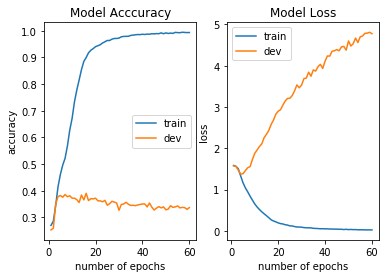

In [50]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)

# ADAPT CODE BELOW
bs = 200
n_epochs = 60 #train accuracy at 100% with 60

history = model.fit(x_train_tf, y_train_tf, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev_tf, y_dev_tf))

#history.history.keys()
plt.subplot(1,2,1)
plt.title("Model Acccuracy") #"acc" on colab "accuracy" on self..
a,=plt.plot(np.arange(n_epochs)+1,history.history["accuracy"],label="train")
b,=plt.plot(np.arange(n_epochs)+1,history.history["val_accuracy"],label="dev")
plt.legend(handles=[a,b])
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
plt.title("Model Loss")
a,=plt.plot(np.arange(n_epochs)+1,history.history["loss"],label="train")
b,=plt.plot(np.arange(n_epochs)+1,history.history["val_loss"],label="dev")
plt.legend(handles=[a,b])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()



In [43]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
#5 epochs in order to avoid overfitting
model.fit(x_train_tf, y_train_tf, batch_size=bs, nb_epoch=40, validation_data=(x_dev_tf, y_dev_tf))

pred=model.predict(x_test_tf)
pred=np.argmax(pred,axis=1) 
with open("logreg_lstm_y_test_sst.txt",'w') as f:
    for p in pred:
        f.write(str(p)+'\n')

Train on 8544 samples, validate on 1101 samples
Epoch 1/40
8544/8544 [==============================] - 5s 583us/sample - loss: 1.5815 - accuracy: 0.2692 - val_loss: 1.5708 - val_accuracy: 0.2534
Epoch 2/40
8544/8544 [==============================] - 4s 429us/sample - loss: 1.5607 - accuracy: 0.2808 - val_loss: 1.5632 - val_accuracy: 0.2534
Epoch 3/40
8544/8544 [==============================] - 4s 419us/sample - loss: 1.5172 - accuracy: 0.3085 - val_loss: 1.5241 - val_accuracy: 0.3361
Epoch 4/40
8544/8544 [==============================] - 4s 442us/sample - loss: 1.3880 - accuracy: 0.4212 - val_loss: 1.4490 - val_accuracy: 0.3688
Epoch 5/40
8544/8544 [==============================] - 4s 446us/sample - loss: 1.2114 - accuracy: 0.5136 - val_loss: 1.4316 - val_accuracy: 0.3806
Epoch 6/40
8544/8544 [==============================] - 4s 427us/sample - loss: 1.0647 - accuracy: 0.5813 - val_loss: 1.4939 - val_accuracy: 0.3797
Epoch 7/40
8544/8544 [==============================] - 4s 448us

## 4.3 - innovate !

In [40]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

from tensorflow.keras.layers import Bidirectional
bs = 200
n_epochs = 20
# Now I will try to use bigger embeddings and use a Bilstm 
model=Sequential()
model.add(Embedding(vocab_size, 60))
model.add(Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)

model.summary()
history=model.fit(x_train_tf, y_train_tf, batch_size=bs, nb_epoch=n_epochs, validation_data=(x_dev_tf, y_dev_tf))

#history.history.keys()
plt.subplot(1,2,1)
plt.title("Model Acccuracy") #"acc" on colab "accuracy" on self..
a,=plt.plot(np.arange(n_epochs)+1,history.history["acc"],label="train")
b,=plt.plot(np.arange(n_epochs)+1,history.history["val_acc"],label="dev")
plt.legend(handles=[a,b])
plt.xlabel("number of epochs")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
plt.title("Model Loss")
a,=plt.plot(np.arange(n_epochs)+1,history.history["loss"],label="train")
b,=plt.plot(np.arange(n_epochs)+1,history.history["val_loss"],label="dev")
plt.legend(handles=[a,b])
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.show()

pred=model.predict(x_test_tf)
pred=np.argmax(pred,axis=1) 
with open("logreg_bilstmpreemb_y_test_sst.text",'w') as f:
    for p in pred:
        f.write(str(p)+'\n')


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 45)          2250000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               618496    
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 2565      
Total params: 2,871,061
Trainable params: 2,871,061
Non-trainable params: 0
_________________________________________________________________
Train on 8544 samples, validate on 1101 samples
Epoch 1/80
3200/8544 [==========>...................] - ETA: 19s - loss: 1.5814 - accuracy: 0.2657

KeyboardInterrupt: 